In [2]:
%pip install pytreeclass jaxtyping jaxlib optax matplotlib

  Using cached pytreeclass-0.3.4-py3-none-any.whl (51 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
from __future__ import annotations

import jax
import jax.numpy as jnp
import numpy as np
import re
from jaxtyping import Array, Float, Int
import pytreeclass as pytc
from typing import Generator
from functools import partial
from copy import deepcopy


def prepare_text(file_name, sentence_length):
    with open(file_name, "r+") as file:
        all_text = file.read()
        # all_text = all_text.replace('\n', ' ').replace('  : ', '')

    # Define a regular expression pattern to match all punctuation marks
    punctuation_pattern = r"[^\w\s]"

    # Define a regular expression pattern to match words with apostrophes
    apostrophe_pattern = r"\w+(?:\'\w+)?"
    # Define a regular expression pattern to match newlines
    newline_pattern = r"\n"

    # Combine the three patterns to match all tokens
    token_pattern = (
        punctuation_pattern + "|" + apostrophe_pattern + "|" + newline_pattern
    )

    # Split the text into tokens, including words with apostrophes as separate tokens
    all_words = re.findall(token_pattern, all_text.lower())
    vocab = list(set(all_words))

    vocab_one_hot_indicies = jnp.array(
        [vocab.index(t) for t in all_words], dtype=jnp.int32
    )
    split_indicies = vocab_one_hot_indicies[
        : (len(vocab) // sentence_length) * sentence_length
    ].reshape(len(vocab) // sentence_length, sentence_length)
    # make last word random, shouldn't make too much of an impact (could be better handled with special char?)
    split_indicies_labels = jnp.concatenate(
        (
            vocab_one_hot_indicies[
                1 : ((len(vocab) - 1) // sentence_length) * sentence_length
            ],
            jnp.array([0]),
        )
    ).reshape((len(vocab) - 1) // sentence_length, sentence_length)
    partition_index = 6 * int(len(split_indicies) / 7)
    train = split_indicies[:partition_index]
    train_labels = split_indicies_labels[:partition_index]
    valid = split_indicies[partition_index:]
    valid_labels = split_indicies_labels[partition_index:]

    return train, train_labels, valid, valid_labels, vocab

In [4]:
file_name = "one-fish-two-fish.txt"
sentence_length = 8  # keep even because of how we split the data
train, train_labels, valid, valid_labels, vocab = prepare_text(
    file_name, sentence_length
)

print(f"examples from vocab: {vocab[:10]}")
print(f"total length of vocab: {len(vocab)} unique words")
print(
    f"total length of training data: {len(train)} sentences (each {sentence_length} words)"
)
print(
    f"total length of validation data: {len(valid)} sentences (each {sentence_length} words)"
)

examples from vocab: ['say', 'light', 'found', 'dog', 'wet', 'never', 'seven', 'brush', 'is', 'likes']
total length of vocab: 300 unique words
total length of training data: 30 sentences (each 8 words)
total length of validation data: 7 sentences (each 8 words)


In [5]:
# first sentence in train set
train[0]

Array([272,  18, 133,  30,  18, 133,  97,  18], dtype=int32)

In [6]:
# first sentence in train labels == same sentence shifted by one word
# i.e. equivalent to train[0][1:] + train[1][0]
train_labels[0]

Array([ 18, 133,  30,  18, 133,  97,  18, 133], dtype=int32)

In [7]:
# we can reconstruct a sentence by mapping indicies back to words
" ".join([vocab[i] for i in train[0]])

'one fish , two fish , red fish'

In [8]:
" ".join([vocab[i] for i in train_labels[0]])

'fish , two fish , red fish ,'

In [9]:
fish_idx = vocab.index("fish")  # the index of the word "fish" in the vocab
one_hot_fish = np.zeros(len(vocab))  # a vector of zeros with length equal to the vocab
one_hot_fish[fish_idx] = 1  # set the index of the word "fish" to 1

# the syntax in JAX is a little different, but the idea is the same
# we use the `at` method to set the value at a particular index,
# and the `set` method to set the value at that index to 1.
# this is due to the fact that JAX arrays are immutable,
# so we can't just set the value at an index to 1 directly!
fish_idx = vocab.index("fish")
one_hot_fish = jnp.zeros(len(vocab))
one_hot_fish = one_hot_fish.at[fish_idx].set(1)

one_hot_fish

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [10]:
def one_hot_sentence(
    sentence: Int[Array, "sentence"], vocab_size: int
) -> Int[Array, "sentence vocab"]:
    return jnp.array([jnp.zeros((vocab_size,)).at[word].set(1) for word in sentence])


# make a very intelligent sentence of all "fish"
fish_sentence = jnp.array([fish_idx] * 10)

# one hot encode the sentence
one_hot_fish_sentence = one_hot_sentence(fish_sentence, len(vocab))

# assert that the sentence is one hot encoded correctly
assert jnp.all(one_hot_fish_sentence == jnp.array([one_hot_fish] * 10))

In [11]:
# we can use `vmap` to automatically transform the function to work on a batch of sentences!
# this will be useful when we want to train our model on multiple sentences at once.
# note that we need to specify the `in_axes` argument to tell JAX which argument
# in the function is the one that we want to map over (in this case, we want to
# map over the first axis of the `sentence` argument, indicated by `0`).
# we also need to specify `None` for the `vocab_size` argument, since it is not
# being mapped over -- it is the same for every sentence in the batch.
batch_one_hot = jax.vmap(one_hot_sentence, in_axes=(0, None))

In [12]:
# This is a container for all the free parameters of an RNN!
# You can see the shapes of each attribute from the type annotations.
# We have a couple of sizes: hidden_state, embedding, vocab
# -> these represent the size of the hidden state weights,
#    the embedding matrix, and the vocabulary respectively.
# This parameters object will be passed to most functions below:
# e.g. access the output weights by calling `params.output_weights` etc.
class Parameters(pytc.TreeClass):
    embedding_weights: Float[Array, "hidden_state embedding"]
    hidden_state_weights: Float[Array, "hidden_state hidden_state"]
    output_weights: Float[Array, "vocab hidden_state"]
    hidden_state_bias: Float[Array, "hidden_state"]
    output_bias: Float[Array, "vocab"]
    embedding_matrix: Float[Array, "embedding vocab"]


# we'll initialize our parameters randomly, but close to 0/identity so that
# we don't have exploding gradients later on!

# set sizes for embeddings, hidden state, vocab, and output vectors
e = 30
h = 16
v = len(vocab)
o = v

params = Parameters(
    embedding_weights=jax.random.truncated_normal(
        lower=-0.1, upper=0.1, shape=[h, e], key=jax.random.PRNGKey(0)
    ),
    hidden_state_weights=jnp.identity(h),
    output_weights=jax.random.truncated_normal(
        lower=-0.1, upper=0.1, shape=[o, h], key=jax.random.PRNGKey(0)
    ),
    hidden_state_bias=jnp.zeros((h,)),
    output_bias=jnp.zeros(
        shape=[
            o,
        ]
    ),
    embedding_matrix=jax.random.truncated_normal(
        lower=-0.1, upper=0.1, shape=[e, v], key=jax.random.PRNGKey(0)
    ),
)

# let's inspect the structure of our parameters
print(pytc.tree_summary(params))
print(pytc.tree_diagram(params))

┌─────────────────────┬───────────┬──────┐
│Name                 │Type       │Count │
├─────────────────────┼───────────┼──────┤
│.embedding_weights   │f32[16,30] │480   │
├─────────────────────┼───────────┼──────┤
│.hidden_state_weights│f32[16,16] │256   │
├─────────────────────┼───────────┼──────┤
│.output_weights      │f32[300,16]│4,800 │
├─────────────────────┼───────────┼──────┤
│.hidden_state_bias   │f32[16]    │16    │
├─────────────────────┼───────────┼──────┤
│.output_bias         │f32[300]   │300   │
├─────────────────────┼───────────┼──────┤
│.embedding_matrix    │f32[30,300]│9,000 │
├─────────────────────┼───────────┼──────┤
│Σ                    │Parameters │14,852│
└─────────────────────┴───────────┴──────┘
Parameters
├── .embedding_weights=f32[16,30](μ=-0.00, σ=0.06, ∈[-0.10,0.10])
├── .hidden_state_weights=f32[16,16](μ=0.06, σ=0.24, ∈[0.00,1.00])
├── .output_weights=f32[300,16](μ=-0.00, σ=0.06, ∈[-0.10,0.10])
├── .hidden_state_bias=f32[16](μ=0.00, σ=0.00, ∈[0.00,0.00])


We'll come to use most of these values later, but for now, we're just focused on embeddings!

Recall what we did in the previous sessions, looking at RNNs for *language modelling*, where every word is turned into a one-hot vector (or "token"). We then multiply these one-hot words by an *embedding matrix* $E$, which multiplies the words to reduce the dimension of that long one-hot vector (=size of the whole vocabulary) to some specified lower dimensional representation (normally ~100 ish). This embedded word is then used to update the hidden state $h$ of the RNN.

Use the embedding matrix (accessible through `params.embedding_matrix`) to fill in the function below, which embeds a single word.

In [13]:
def make_embeddings(
    one_hot_word: Float[Array, "vocab"], params: Parameters
) -> Float[Array, "embedding"]:
    return params.embedding_matrix @ one_hot_word


# I should be a vector of length `e`
assert make_embeddings(one_hot_fish, params).shape == (e,)

In [14]:
# map to work over sentences for later!
embeddings_map = jax.vmap(make_embeddings, in_axes=(0, None))

In [15]:
def update_hidden_state(
    embedding: Float[Array, "embedding"],
    hidden_state: Float[Array, "hidden_state"],
    params: Parameters,
) -> Float[Array, "hidden_state"]:
    return jax.nn.tanh(
        params.hidden_state_weights @ hidden_state
        + params.embedding_weights @ embedding
        + params.hidden_state_bias
    )


# I should be a vector of length `h`
embedding = make_embeddings(one_hot_fish, params)
assert update_hidden_state(embedding, jnp.zeros((h,)), params).shape == (h,)

In [16]:
def output(
    hidden_state: Float[Array, "hidden_state"], params: Parameters
) -> Float[Array, "vocab"]:
    return jax.nn.softmax(params.output_weights @ hidden_state + params.output_bias)


# I should be a vector of length `v`
assert output(jnp.zeros((h,)), params).shape == (v,)

In [17]:
def rnn(
    data: Float[Array, "sentence vocab"], params: Parameters, hidden_size: int
) -> Float[Array, "sentence vocab"]:
    # apply embeddings_map to create a vector of embeddings
    embeddings = embeddings_map(data, params)  # ["sentence embedding"]

    # initialize the hidden state with zeros
    hidden_state = jnp.zeros((hidden_size,))

    # for each word in the vector of embeddings:
    #   > update the hidden state
    #   > compute the output word using that hidden state and store it
    # return the set of outputs
    outputs = []

    for word in embeddings:
        hidden_state = update_hidden_state(word, hidden_state, params)
        outputs.append(output(hidden_state, params))

    return jnp.array(outputs)


# make a very intelligent sentence of all "fish"
fish_sentence = jnp.array([fish_idx] * 10)
one_hot_fish_sentence = one_hot_sentence(fish_sentence, len(vocab))

# run the RNN on "fish fish fish fish fish fish fish fish fish fish"
rnn_outputs = rnn(one_hot_fish_sentence, params, h)

# the output should be a list of 10 vectors of length `v`
# corresponding to the output probabilities at each position in the sentence
assert rnn_outputs.shape == (10, v)

# what is the most likely word at each position?
# (remember that we have randomly initialized our parameters, so this will be nonsense!)
most_likely_words = [vocab[jnp.argmax(output)] for output in rnn_outputs]
most_likely_words

['one', 'one', 'one', 'one', 'one', 'one', 'one', 'one', 'one', 'one']

In [18]:
def loss(
    output: Float[Array, "vocab"], next_one_hot_word: Float[Array, "vocab"]
) -> Float[Array, ""]:
    # index the softmax probs at the word of interest
    return -jnp.log(output[jnp.argmax(next_one_hot_word)])


sentence_loss = jax.vmap(loss, in_axes=(0, 0))

In [19]:
def forward_pass(
    data: Float[Array, "sentence vocab"],
    next_words: Float[Array, "sentence vocab"],  # data shifted by 1 to the right
    params: Parameters,
    hidden_size: int,
) -> Float[Array, ""]:
    output = rnn(data, params, hidden_size)
    return sentence_loss(output, next_words).mean(axis=0)


# run the forward pass on our fish sentence
loss_value = forward_pass(one_hot_fish_sentence, one_hot_fish_sentence, params, h)
assert loss_value.shape == ()
print(f"starting loss: {loss_value:.2f}")

# here, we transform the forward pass into the gradient function,
# and also vmap again so it can handle a batch of sentences instead of one.
loss_and_gradient = jax.value_and_grad(forward_pass, argnums=2)
print("gradients are packed up in a Parameters object:")
print(
    pytc.tree_diagram(
        loss_and_gradient(one_hot_fish_sentence, one_hot_fish_sentence, params, h)[1]
    )
)

starting loss: 5.68
gradients are packed up in a Parameters object:
Parameters
├── .embedding_weights=f32[16,30](μ=-0.00, σ=0.01, ∈[-0.04,0.04])
├── .hidden_state_weights=f32[16,16](μ=0.00, σ=0.01, ∈[-0.04,0.04])
├── .output_weights=f32[300,16](μ=0.00, σ=0.01, ∈[-0.16,0.11])
├── .hidden_state_bias=f32[16](μ=0.10, σ=0.22, ∈[-0.41,0.44])
├── .output_bias=f32[300](μ=0.00, σ=0.06, ∈[-1.00,0.00])
└── .embedding_matrix=f32[30,300](μ=-0.00, σ=0.00, ∈[-0.14,0.10])


In [20]:
# we can also vmap the gradient function to handle a batch of sentences,
# and jit it to make it faster!
batched_grads = jax.jit(
    jax.vmap(loss_and_gradient, in_axes=(0, 0, None, None)), static_argnums=(3,)
)

In [21]:
def predict_next_words(
    prompt: str,
    vocab: list[str],
    rnn_params: Parameters,
    rnn_hidden_size: int,
    num_predicted_tokens: int,
    include_prompt=True,
) -> str:
    # Define a regular expression pattern to match all punctuation marks
    punctuation_pattern = r"[^\w\s]"

    # Define a regular expression pattern to match words with apostrophes
    apostrophe_pattern = r"\w+(?:\'\w+)?"
    # Define a regular expression pattern to match newlines
    newline_pattern = r"\n"

    # Combine the three patterns to match all tokens
    token_pattern = (
        punctuation_pattern + "|" + apostrophe_pattern + "|" + newline_pattern
    )

    tokens = re.findall(token_pattern, prompt.lower())
    one_hot_indicies = jnp.array([vocab.index(t) for t in tokens], dtype=jnp.int32)
    sentence = one_hot_sentence(one_hot_indicies, len(vocab))
    embeddings = embeddings_map(sentence, rnn_params)  # ["sentence embedding"]

    hidden_state = jnp.zeros((rnn_hidden_size,))
    outputs = [None] * num_predicted_tokens
    for word in embeddings[:-1]:
        hidden_state = update_hidden_state(word, hidden_state, rnn_params)
    hidden_state = update_hidden_state(embeddings[-1], hidden_state, rnn_params)
    outputs[0] = output(hidden_state, rnn_params)

    for i in range(1, num_predicted_tokens):
        embedded_pred = make_embeddings(outputs[i - 1], rnn_params)
        hidden_state = update_hidden_state(embedded_pred, hidden_state, rnn_params)
        outputs[i] = output(hidden_state, rnn_params)

    res = jnp.array(outputs)
    res_indicies = jnp.argmax(res, axis=1)
    words = [vocab[i] for i in res_indicies]
    out = " ".join(words)
    return prompt + " | " + out if include_prompt else out

In [22]:
batch_size = 400

import numpy.random as npr


def batches(training_data: Array, batch_size: int) -> Generator:
    num_train = training_data.shape[0]
    num_complete_batches, leftover = divmod(num_train, batch_size)
    num_batches = num_complete_batches + bool(leftover)

    # batching mechanism, ripped from the JAX docs :)
    def data_stream():
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size : (i + 1) * batch_size]
                yield train[batch_idx], train_labels[batch_idx]

    return data_stream()


batch = batches(train, batch_size)
one_hot_valid, one_hot_valid_labels = batch_one_hot(valid, len(vocab)), batch_one_hot(
    valid_labels, len(vocab)
)

#### Setting up training hyperparameters

In [23]:
# training hyperparams, modify at will!
num_iter = 2000
lr = 4e-2
best_loss = 999
best_pars = None


# basic gradient descent
def gradient_descent(param: jax.Array, grads: jax.Array) -> jax.Array:
    return param - lr * grads.mean(axis=0)


# more advanced gradient descent
import optax

opt = optax.chain(
    optax.clip(1),
    optax.adamw(learning_rate=lr),
)
opt_state = opt.init(params)

### Train time!

In [28]:
for i in range(num_iter):
    sentences, sentence_labels = next(batch)
    one_hot_sentences, one_hot_sentence_labels = batch_one_hot(
        sentences, v
    ), batch_one_hot(sentence_labels, v)
    loss, grads = batched_grads(one_hot_sentences, one_hot_sentence_labels, params, h)
    valid_loss, _ = batched_grads(one_hot_valid, one_hot_valid_labels, params, h)
    loss, valid_loss = loss.mean(), valid_loss.mean()

    # gradient descent!
    params = jax.tree_map(gradient_descent, params, grads)

    ## uncomment these lines for advanced version
    # avg_grads = jax.tree_map(lambda g: g.mean(axis=0), grads)
    # updates, opt_state = opt.update(avg_grads, opt_state, params=pars)
    # pars = optax.apply_updates(pars, updates)

    if valid_loss < best_loss:
        best_pars = deepcopy(params)
        best_loss = valid_loss
    if i % 20 == 0:
        print(f"train loss: {loss.mean():.3f}", end=", ")
        print(f"valid loss: {valid_loss.mean():.3f}")

print(f"best valid loss: {best_loss:.3f}")
print(predict_next_words("Red fish ", vocab, params, h, 10, include_prompt=True))

train loss: 5.706, valid loss: 5.705
train loss: 5.656, valid loss: 5.660
train loss: 5.589, valid loss: 5.599
train loss: 5.485, valid loss: 5.505
train loss: 5.337, valid loss: 5.368
train loss: 5.158, valid loss: 5.202
train loss: 4.978, valid loss: 5.039
train loss: 4.827, valid loss: 4.910
train loss: 4.714, valid loss: 4.825
train loss: 4.628, valid loss: 4.774
train loss: 4.562, valid loss: 4.744
train loss: 4.508, valid loss: 4.727
train loss: 4.463, valid loss: 4.717
train loss: 4.424, valid loss: 4.712
train loss: 4.390, valid loss: 4.709
train loss: 4.359, valid loss: 4.708
train loss: 4.332, valid loss: 4.707
train loss: 4.307, valid loss: 4.707
train loss: 4.284, valid loss: 4.708
train loss: 4.264, valid loss: 4.709
train loss: 4.245, valid loss: 4.710
train loss: 4.227, valid loss: 4.712
train loss: 4.211, valid loss: 4.713
train loss: 4.196, valid loss: 4.715
train loss: 4.182, valid loss: 4.717
train loss: 4.168, valid loss: 4.719
train loss: 4.156, valid loss: 4.721
t

In [30]:
predict_next_words("Red fish ", vocab, params, h, 10, include_prompt=True)

'Red fish  | \n \n \n \n \n \n \n \n \n \n'

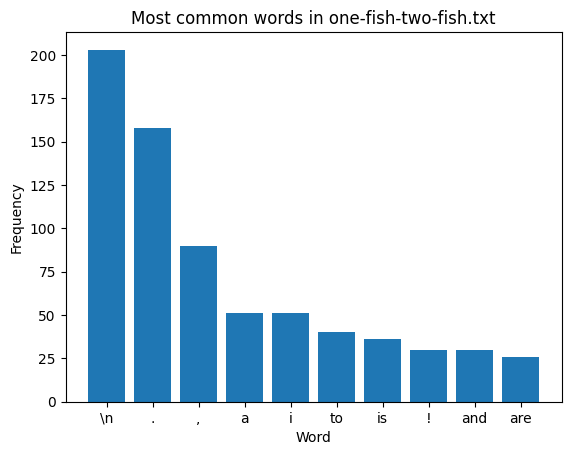

In [46]:
# make a histogram of the frequency of each word in the document
import matplotlib.pyplot as plt
from collections import Counter

with open(file_name, "r+") as file:
    all_text = file.read()

# Define a regular expression pattern to match all punctuation marks
punctuation_pattern = r"[^\w\s]"

# Define a regular expression pattern to match words with apostrophes
apostrophe_pattern = r"\w+(?:\'\w+)?"
# Define a regular expression pattern to match newlines
newline_pattern = r"\n"

# Combine the three patterns to match all tokens
token_pattern = punctuation_pattern + "|" + apostrophe_pattern + "|" + newline_pattern

# Split the text into tokens, including words with apostrophes as separate tokens
all_words = re.findall(token_pattern, all_text.lower())

# Count the number of occurrences of each word
word_counts = Counter(all_words)

# Get the 100 most common words
most_common_words = word_counts.most_common(10)

# Plot the histogram
plt.bar(
    [word for word, count in most_common_words],
    [count for word, count in most_common_words],
)

# the x-labels will not escape the newlines, so we need to replace them
plt.xticks(
    [word for word, count in most_common_words],
    [word.replace("\n", r"\n") for word, _ in most_common_words],
)
plt.xlabel("Word")
plt.ylabel("Frequency")
plt.title(f"Most common words in {file_name}")
plt.show()